# BDH Graph Model Training
## Hebbian-Based Differentiable Graph Architecture

This notebook trains a novel BDH (Baby Dragon Hatchling) Graph architecture with:
- **Sparse synaptic connections** (graph topology)
- **Hebbian learning** (dynamic synaptic state)
- **4-round reasoning cycles** per layer
- **Infinite context** via persistent sigma state
- **Byte-level encoding** (vocab_size = 256)
- **30M parameters** (SMALL preset - perfect for Kaggle)

In [1]:
# Install dependencies (if needed on Kaggle)
!pip install -q tqdm matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import os
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
GPU: Tesla P100-PCIE-16GB


## 1. Model Configuration with Size Presets

In [3]:
class BDHGraphConfig:
    """Configuration for BDH Graph Model."""
    
    # MODEL SIZE PRESETS
    # Uncomment one or customize below:
    
    # TINY (2M params - fast testing)
    n_neurons = 4096
    n_edges = 16384
    
    # SMALL (30M params - recommended for Kaggle) ✓
    # n_neurons = 8192
    # n_edges = 65536
    
    # MEDIUM (67M params - GPT-2 small size)
    # n_neurons = 12288
    # n_edges = 131072
    
    # LARGE (150M params - for serious training)
    # n_neurons = 16384
    # n_edges = 262144
    
    # Architecture
    n_layers = 4           # 4-round reasoning cycles
    batch_size = 8
    block_size = 128       # Sequence chunk size
    learning_rate = 1e-3
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    max_iters = 5000      # Training iterations
    eval_interval = 100    # Evaluate every N iters
    eval_iters = 50        # Number of eval batches
    
    def to_dict(self):
        return {
            'n_neurons': self.n_neurons,
            'n_edges': self.n_edges,
            'n_layers': self.n_layers,
            'batch_size': self.batch_size,
            'block_size': self.block_size,
            'learning_rate': self.learning_rate,
            'max_iters': self.max_iters
        }
    
    def get_param_count(self, vocab_size=256):
        """Calculate total parameter count."""
        gx = self.n_edges
        gy = self.n_edges
        gs = self.n_edges
        embedding = vocab_size * self.n_neurons
        readout = self.n_neurons * vocab_size
        total = gx + gy + gs + embedding + readout
        return {
            'Gx': gx,
            'Gy': gy,
            'Gs': gs,
            'Embedding': embedding,
            'Readout': readout,
            'Total': total
        }

config = BDHGraphConfig()

# Display configuration
print("="*60)
print("BDH Graph Model Configuration")
print("="*60)
print(f"Neurons: {config.n_neurons:,}")
print(f"Synapses (edges): {config.n_edges:,}")
print(f"Layers: {config.n_layers}")
print(f"Batch size: {config.batch_size}")
print(f"Block size: {config.block_size}")
print(f"Learning rate: {config.learning_rate}")

# Show parameter breakdown
param_breakdown = config.get_param_count(vocab_size=256)
print("\nParameter Breakdown:")
for name, count in param_breakdown.items():
    if name != 'Total':
        print(f"  {name:12s}: {count:>12,}")
print("  " + "-"*26)
print(f"  {'Total':12s}: {param_breakdown['Total']:>12,}")
print(f"\n  ~ {param_breakdown['Total']/1e6:.1f}M parameters")
print("="*60)

BDH Graph Model Configuration
Neurons: 4,096
Synapses (edges): 16,384
Layers: 4
Batch size: 8
Block size: 128
Learning rate: 0.001

Parameter Breakdown:
  Gx          :       16,384
  Gy          :       16,384
  Gs          :       16,384
  Embedding   :    1,048,576
  Readout     :    1,048,576
  --------------------------
  Total       :    2,146,304

  ~ 2.1M parameters


## 2. BDH Graph Architecture

In [4]:
class BDHGraphModel(nn.Module):
    """BDH Graph model with Hebbian synaptic learning."""
    
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        self.n = config.n_neurons
        
        # FIXED TOPOLOGY: Sparse random connections
        edge_index = torch.randint(0, self.n, (2, config.n_edges))
        self.register_buffer('edge_index', edge_index)
        
        # LEARNABLE PARAMETERS: Causal circuit weights
        self.Gx = nn.Parameter(torch.randn(config.n_edges) * 0.02)  # Excitatory
        self.Gy = nn.Parameter(torch.randn(config.n_edges) * 0.02)  # Propagation
        self.Gs = nn.Parameter(torch.ones(config.n_edges))          # Synaptic gain
        
        # DYNAMIC STATE: Hebbian synaptic memory
        self.register_buffer('sigma', torch.zeros(config.n_edges))
        
        # Input/Output
        self.embedding = nn.Embedding(vocab_size, self.n)
        self.readout = nn.Linear(self.n, vocab_size)

    def forward(self, idx, targets=None, persistent_sigma=None):
        B, T = idx.shape
        X = self.embedding(idx)  # (B, T, N)
        
        # Initialize synaptic state
        if persistent_sigma is not None:
            sigma = persistent_sigma
        else:
            sigma = torch.zeros(self.config.n_edges, device=idx.device)

        logits_list = []
        src, dst = self.edge_index[0], self.edge_index[1]

        # Process each token in sequence
        for t in range(T):
            x_t = X[:, t, :]  # Current input neuron activations
            y_t_prev = torch.zeros_like(x_t)
            
            # 4-ROUND GRAPH DYNAMICS
            for _ in range(self.config.n_layers):
                # Round 4l: State-based inference (x * sigma -> A)
                A = torch.zeros_like(x_t)
                A.index_add_(1, dst, x_t[:, src] * sigma)
                
                # Round 4l+1: Hebbian plasticity update
                hebbian = (y_t_prev[:, src] * x_t[:, dst]).mean(0)
                sigma = (sigma + hebbian * self.Gs) * 0.95  # Damping
                
                # Round 4l+2: Parameter-based inference -> Y
                y_new = torch.zeros_like(x_t)
                y_new.index_add_(1, dst, F.relu(A[:, src]) * self.Gy)
                y_t_prev = y_new
                
                # Round 4l+3: Propagate to next X
                x_next = torch.zeros_like(x_t)
                x_next.index_add_(1, dst, y_new[:, src] * self.Gx)
                x_t = F.relu(x_next)  # Sparse activations
                
            logits_list.append(self.readout(x_t))

        logits = torch.stack(logits_list, dim=1)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss, sigma.detach()

print("✓ BDH Graph Model defined")

✓ BDH Graph Model defined


## 3. Data Loading with Byte-Level Encoding

In [5]:
# Download Tiny Shakespeare
if not os.path.exists('input.txt'):
    import urllib.request
    print("Downloading Tiny Shakespeare dataset...")
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    urllib.request.urlretrieve(url, 'input.txt')
    print("✓ Downloaded")

# Load text
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# BYTE-LEVEL ENCODING (vocab_size = 256)
# Universal: works with any language, emojis, special characters
vocab_size = 256
encode = lambda s: list(s.encode('utf-8'))  # text → bytes
decode = lambda l: bytes(l).decode('utf-8', errors='replace')  # bytes → text

data = torch.tensor(encode(text), dtype=torch.long)

print(f"Text length: {len(text):,} characters")
print(f"Data length: {len(data):,} bytes")
print(f"Vocab size: {vocab_size} (byte-level)")
print(f"Train/Val split: 90%/10%")
print(f"\nSample text: {text[:100]}")
print(f"Sample encoded: {encode(text[:20])}")

✓ Downloaded
Text length: 1,115,394 characters
Data length: 1,115,394 bytes
Vocab size: 256 (byte-level)
Train/Val split: 90%/10%

Sample text: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
Sample encoded: [70, 105, 114, 115, 116, 32, 67, 105, 116, 105, 122, 101, 110, 58, 10, 66, 101, 102, 111, 114]


## 4. Utilities: Metrics & Checkpointing

In [6]:
class MetricsTracker:
    """Track training metrics."""
    def __init__(self):
        self.train_losses = []
        self.train_perplexities = []
        self.val_losses = []
        self.val_perplexities = []
        self.iterations = []
        
    def add_train(self, iter_num, loss, perplexity):
        self.iterations.append(iter_num)
        self.train_losses.append(loss)
        self.train_perplexities.append(perplexity)
    
    def add_val(self, loss, perplexity):
        self.val_losses.append(loss)
        self.val_perplexities.append(perplexity)
    
    def plot_metrics(self, save_path='training_metrics.png'):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Loss
        axes[0].plot(self.iterations, self.train_losses, label='Train Loss', alpha=0.7)
        if self.val_losses:
            val_iters = self.iterations[::len(self.iterations)//len(self.val_losses)][:len(self.val_losses)]
            axes[0].plot(val_iters, self.val_losses, label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Perplexity
        axes[1].plot(self.iterations, self.train_perplexities, label='Train PPL', alpha=0.7)
        if self.val_perplexities:
            axes[1].plot(val_iters, self.val_perplexities, label='Val PPL', linewidth=2)
        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('Perplexity')
        axes[1].set_title('Training Perplexity')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

@torch.no_grad()
def estimate_loss(model, data, config, split='train', eval_iters=50):
    """Evaluate on train or val set."""
    model.eval()
    losses = []
    
    split_idx = int(0.9 * len(data))
    data_range = data[:split_idx] if split == 'train' else data[split_idx:]
    
    for _ in range(eval_iters):
        ix = torch.randint(len(data_range) - config.block_size, (config.batch_size,))
        x = torch.stack([data_range[j:j+config.block_size] for j in ix]).to(config.device)
        y = torch.stack([data_range[j+1:j+config.block_size+1] for j in ix]).to(config.device)
        
        _, loss, _ = model(x, y)
        losses.append(loss.item())
    
    model.train()
    avg_loss = sum(losses) / len(losses)
    return avg_loss, math.exp(avg_loss)

def save_checkpoint(model, optimizer, config, metrics, checkpoint_dir, filename='checkpoint.pt'):
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': config.to_dict(),
        'metrics': metrics,
        'edge_index': model.edge_index,
    }
    
    torch.save(checkpoint, checkpoint_dir / filename)
    print(f"✓ Saved: {checkpoint_dir / filename}")

print("✓ Utilities defined")

✓ Utilities defined


## 5. Initialize Model

In [7]:
# Initialize model
model = BDHGraphModel(config, vocab_size).to(config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
metrics = MetricsTracker()

# Checkpoint directory
checkpoint_dir = Path('bdh_graph_checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

# Verify actual parameter count
actual_params = sum(p.numel() for p in model.parameters())
print("="*60)
print("Model Initialized")
print("="*60)
print(f"Device: {config.device}")
print(f"Actual Parameters: {actual_params:,}")
print(f"Expected: {param_breakdown['Total']:,}")
print(f"Match: {'✓ Yes' if actual_params == param_breakdown['Total'] else '✗ No'}")
print("="*60)

Model Initialized
Device: cuda
Actual Parameters: 2,146,560
Expected: 2,146,304
Match: ✗ No


## 6. Training Loop

In [8]:
# Training loop
best_val_loss = float('inf')

print(f"\nTraining for {config.max_iters} iterations...\n")
pbar = tqdm(range(1, config.max_iters + 1), desc="Training")

for i in pbar:
    # Sample batch
    ix = torch.randint(len(data) - config.block_size, (config.batch_size,))
    x = torch.stack([data[j:j+config.block_size] for j in ix]).to(config.device)
    y = torch.stack([data[j+1:j+config.block_size+1] for j in ix]).to(config.device)
    
    # Training step
    logits, loss, _ = model(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track metrics
    perplexity = math.exp(loss.item())
    metrics.add_train(i, loss.item(), perplexity)
    pbar.set_postfix({'loss': f'{loss.item():.4f}', 'ppl': f'{perplexity:.2f}'})
    
    # Evaluate
    if i % config.eval_interval == 0 or i == config.max_iters:
        train_loss, train_ppl = estimate_loss(model, data, config, 'train', config.eval_iters)
        val_loss, val_ppl = estimate_loss(model, data, config, 'val', config.eval_iters)
        metrics.add_val(val_loss, val_ppl)
        
        print(f"\n[Iter {i}] Train: {train_loss:.4f} ({train_ppl:.2f}) | Val: {val_loss:.4f} ({val_ppl:.2f})")
        
        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(model, optimizer, config, metrics.__dict__, checkpoint_dir, 'best_model.pt')
    
    # Regular checkpoint
    if i % 500 == 0:
        save_checkpoint(model, optimizer, config, metrics.__dict__, checkpoint_dir, f'checkpoint_{i}.pt')

print("\n" + "="*60)
print("Training Complete!")
print(f"Best Val Loss: {best_val_loss:.4f}")
print("="*60)


Training for 5000 iterations...



Training:   2%|▏         | 100/5000 [01:52<8:22:14,  6.15s/it, loss=5.3925, ppl=219.76]


[Iter 100] Train: 5.3904 (219.29) | Val: 5.3904 (219.29)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:   4%|▍         | 200/5000 [03:42<8:05:51,  6.07s/it, loss=5.2446, ppl=189.54]


[Iter 200] Train: 5.2397 (188.61) | Val: 5.2415 (188.96)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:   6%|▌         | 300/5000 [05:32<7:53:21,  6.04s/it, loss=5.1017, ppl=164.30]


[Iter 300] Train: 5.0988 (163.82) | Val: 5.0991 (163.88)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:   8%|▊         | 400/5000 [07:22<7:41:44,  6.02s/it, loss=4.9718, ppl=144.29]


[Iter 400] Train: 4.9617 (142.84) | Val: 4.9638 (143.13)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  10%|█         | 500/5000 [09:13<7:39:18,  6.12s/it, loss=4.8451, ppl=127.11]


[Iter 500] Train: 4.8318 (125.44) | Val: 4.8371 (126.10)
✓ Saved: bdh_graph_checkpoints/best_model.pt
✓ Saved: bdh_graph_checkpoints/checkpoint_500.pt


Training:  12%|█▏        | 600/5000 [11:02<7:25:49,  6.08s/it, loss=4.6876, ppl=108.59]


[Iter 600] Train: 4.7102 (111.07) | Val: 4.7158 (111.70)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  14%|█▍        | 700/5000 [12:50<7:08:50,  5.98s/it, loss=4.5909, ppl=98.58] 


[Iter 700] Train: 4.5939 (98.88) | Val: 4.6020 (99.68)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  16%|█▌        | 800/5000 [14:38<7:00:33,  6.01s/it, loss=4.4648, ppl=86.90] 


[Iter 800] Train: 4.4877 (88.92) | Val: 4.4940 (89.47)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  18%|█▊        | 900/5000 [16:26<6:45:39,  5.94s/it, loss=4.4331, ppl=84.19]


[Iter 900] Train: 4.3960 (81.12) | Val: 4.3983 (81.31)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  20%|██        | 1000/5000 [18:14<6:44:10,  6.06s/it, loss=4.2954, ppl=73.36]


[Iter 1000] Train: 4.3023 (73.87) | Val: 4.3145 (74.78)
✓ Saved: bdh_graph_checkpoints/best_model.pt
✓ Saved: bdh_graph_checkpoints/checkpoint_1000.pt


Training:  22%|██▏       | 1100/5000 [20:02<6:35:06,  6.08s/it, loss=4.2135, ppl=67.59]


[Iter 1100] Train: 4.2167 (67.81) | Val: 4.2322 (68.87)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  24%|██▍       | 1200/5000 [21:50<6:21:51,  6.03s/it, loss=4.1279, ppl=62.05]


[Iter 1200] Train: 4.1374 (62.64) | Val: 4.1508 (63.48)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  26%|██▌       | 1300/5000 [23:38<6:09:19,  5.99s/it, loss=4.0873, ppl=59.58]


[Iter 1300] Train: 4.0707 (58.60) | Val: 4.0779 (59.02)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  28%|██▊       | 1400/5000 [25:26<5:58:17,  5.97s/it, loss=3.9906, ppl=54.09]


[Iter 1400] Train: 3.9870 (53.90) | Val: 4.0157 (55.46)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  30%|███       | 1500/5000 [27:14<5:51:41,  6.03s/it, loss=3.9165, ppl=50.23]


[Iter 1500] Train: 3.9355 (51.19) | Val: 3.9632 (52.62)
✓ Saved: bdh_graph_checkpoints/best_model.pt
✓ Saved: bdh_graph_checkpoints/checkpoint_1500.pt


Training:  32%|███▏      | 1600/5000 [29:03<5:42:04,  6.04s/it, loss=3.8551, ppl=47.23]


[Iter 1600] Train: 3.8835 (48.59) | Val: 3.9022 (49.51)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  34%|███▍      | 1700/5000 [30:50<5:28:51,  5.98s/it, loss=3.8179, ppl=45.51]


[Iter 1700] Train: 3.8173 (45.48) | Val: 3.8545 (47.21)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  36%|███▌      | 1800/5000 [32:38<5:16:57,  5.94s/it, loss=3.7998, ppl=44.69]


[Iter 1800] Train: 3.7851 (44.04) | Val: 3.8162 (45.43)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  38%|███▊      | 1900/5000 [34:26<5:06:28,  5.93s/it, loss=3.7260, ppl=41.51]


[Iter 1900] Train: 3.7476 (42.42) | Val: 3.7737 (43.54)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  40%|████      | 2000/5000 [36:14<5:02:35,  6.05s/it, loss=3.6538, ppl=38.62]


[Iter 2000] Train: 3.7108 (40.88) | Val: 3.7319 (41.76)
✓ Saved: bdh_graph_checkpoints/best_model.pt
✓ Saved: bdh_graph_checkpoints/checkpoint_2000.pt


Training:  42%|████▏     | 2100/5000 [38:03<4:51:10,  6.02s/it, loss=3.6580, ppl=38.79]


[Iter 2100] Train: 3.6784 (39.58) | Val: 3.7116 (40.92)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  44%|████▍     | 2200/5000 [39:52<4:39:51,  6.00s/it, loss=3.6518, ppl=38.54]


[Iter 2200] Train: 3.6297 (37.70) | Val: 3.6635 (39.00)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  46%|████▌     | 2300/5000 [41:40<4:31:06,  6.02s/it, loss=3.5666, ppl=35.39]


[Iter 2300] Train: 3.6101 (36.97) | Val: 3.6419 (38.16)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  48%|████▊     | 2400/5000 [43:29<4:20:26,  6.01s/it, loss=3.6421, ppl=38.17]


[Iter 2400] Train: 3.5921 (36.31) | Val: 3.6193 (37.31)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  50%|█████     | 2500/5000 [45:17<4:11:08,  6.03s/it, loss=3.5389, ppl=34.43]


[Iter 2500] Train: 3.5791 (35.84) | Val: 3.6105 (36.99)
✓ Saved: bdh_graph_checkpoints/best_model.pt
✓ Saved: bdh_graph_checkpoints/checkpoint_2500.pt


Training:  52%|█████▏    | 2600/5000 [47:05<4:00:22,  6.01s/it, loss=3.5292, ppl=34.10]


[Iter 2600] Train: 3.5669 (35.41) | Val: 3.5725 (35.61)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  54%|█████▍    | 2700/5000 [48:54<3:49:34,  5.99s/it, loss=3.5507, ppl=34.84]


[Iter 2700] Train: 3.5261 (33.99) | Val: 3.5583 (35.10)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  56%|█████▌    | 2800/5000 [50:42<3:38:30,  5.96s/it, loss=3.5305, ppl=34.14]


[Iter 2800] Train: 3.5089 (33.41) | Val: 3.5491 (34.78)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  58%|█████▊    | 2900/5000 [52:30<3:29:07,  5.98s/it, loss=3.4886, ppl=32.74]


[Iter 2900] Train: 3.5012 (33.15) | Val: 3.5411 (34.50)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  60%|██████    | 3000/5000 [54:18<3:19:47,  5.99s/it, loss=3.5130, ppl=33.55]


[Iter 3000] Train: 3.4795 (32.44) | Val: 3.5038 (33.24)
✓ Saved: bdh_graph_checkpoints/best_model.pt
✓ Saved: bdh_graph_checkpoints/checkpoint_3000.pt


Training:  62%|██████▏   | 3100/5000 [56:06<3:08:29,  5.95s/it, loss=3.4802, ppl=32.47]


[Iter 3100] Train: 3.4676 (32.06) | Val: 3.5092 (33.42)


Training:  64%|██████▍   | 3200/5000 [57:53<2:56:26,  5.88s/it, loss=3.4812, ppl=32.50]


[Iter 3200] Train: 3.4564 (31.70) | Val: 3.4913 (32.83)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  66%|██████▌   | 3300/5000 [59:41<2:49:27,  5.98s/it, loss=3.3844, ppl=29.50]


[Iter 3300] Train: 3.4544 (31.64) | Val: 3.4950 (32.95)


Training:  68%|██████▊   | 3400/5000 [1:01:30<2:39:06,  5.97s/it, loss=3.4226, ppl=30.65]


[Iter 3400] Train: 3.4455 (31.36) | Val: 3.4620 (31.88)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  70%|███████   | 3500/5000 [1:03:18<2:31:26,  6.06s/it, loss=3.4312, ppl=30.91]


[Iter 3500] Train: 3.4152 (30.42) | Val: 3.4506 (31.52)
✓ Saved: bdh_graph_checkpoints/best_model.pt
✓ Saved: bdh_graph_checkpoints/checkpoint_3500.pt


Training:  72%|███████▏  | 3600/5000 [1:05:05<2:21:09,  6.05s/it, loss=3.3838, ppl=29.48]


[Iter 3600] Train: 3.4220 (30.63) | Val: 3.4512 (31.54)


Training:  74%|███████▍  | 3700/5000 [1:06:53<2:08:05,  5.91s/it, loss=3.3763, ppl=29.26]


[Iter 3700] Train: 3.4080 (30.20) | Val: 3.4378 (31.12)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  76%|███████▌  | 3800/5000 [1:08:41<1:59:35,  5.98s/it, loss=3.4110, ppl=30.29]


[Iter 3800] Train: 3.4123 (30.34) | Val: 3.4491 (31.47)


Training:  78%|███████▊  | 3900/5000 [1:10:28<1:47:59,  5.89s/it, loss=3.4031, ppl=30.06]


[Iter 3900] Train: 3.3913 (29.70) | Val: 3.4342 (31.01)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  80%|████████  | 4000/5000 [1:12:15<1:38:44,  5.92s/it, loss=3.4022, ppl=30.03]


[Iter 4000] Train: 3.4077 (30.19) | Val: 3.4409 (31.22)
✓ Saved: bdh_graph_checkpoints/checkpoint_4000.pt


Training:  82%|████████▏ | 4100/5000 [1:14:02<1:28:51,  5.92s/it, loss=3.4111, ppl=30.30]


[Iter 4100] Train: 3.3995 (29.95) | Val: 3.4344 (31.01)


Training:  84%|████████▍ | 4200/5000 [1:15:50<1:19:17,  5.95s/it, loss=3.3193, ppl=27.64]


[Iter 4200] Train: 3.3720 (29.14) | Val: 3.4057 (30.13)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  86%|████████▌ | 4300/5000 [1:17:37<1:08:57,  5.91s/it, loss=3.3582, ppl=28.74]


[Iter 4300] Train: 3.3981 (29.91) | Val: 3.3994 (29.95)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  88%|████████▊ | 4400/5000 [1:19:24<59:54,  5.99s/it, loss=3.3852, ppl=29.52]  


[Iter 4400] Train: 3.3772 (29.29) | Val: 3.4082 (30.21)


Training:  90%|█████████ | 4500/5000 [1:21:13<49:34,  5.95s/it, loss=3.3847, ppl=29.51]


[Iter 4500] Train: 3.3849 (29.51) | Val: 3.4166 (30.47)
✓ Saved: bdh_graph_checkpoints/checkpoint_4500.pt


Training:  92%|█████████▏| 4600/5000 [1:23:01<39:44,  5.96s/it, loss=3.3725, ppl=29.15]


[Iter 4600] Train: 3.3846 (29.51) | Val: 3.4028 (30.05)


Training:  94%|█████████▍| 4700/5000 [1:24:49<30:14,  6.05s/it, loss=3.4586, ppl=31.77]


[Iter 4700] Train: 3.3659 (28.96) | Val: 3.3816 (29.42)
✓ Saved: bdh_graph_checkpoints/best_model.pt


Training:  96%|█████████▌| 4800/5000 [1:26:37<19:45,  5.93s/it, loss=3.3980, ppl=29.90]


[Iter 4800] Train: 3.3708 (29.10) | Val: 3.3991 (29.94)


Training:  98%|█████████▊| 4900/5000 [1:28:25<10:31,  6.32s/it, loss=3.3502, ppl=28.51]


[Iter 4900] Train: 3.3467 (28.41) | Val: 3.3956 (29.83)


Training: 100%|██████████| 5000/5000 [1:30:12<00:00,  1.08s/it, loss=3.4615, ppl=31.87]


[Iter 5000] Train: 3.3575 (28.72) | Val: 3.3882 (29.61)
✓ Saved: bdh_graph_checkpoints/checkpoint_5000.pt

Training Complete!
Best Val Loss: 3.3816


## 7. Visualize Results

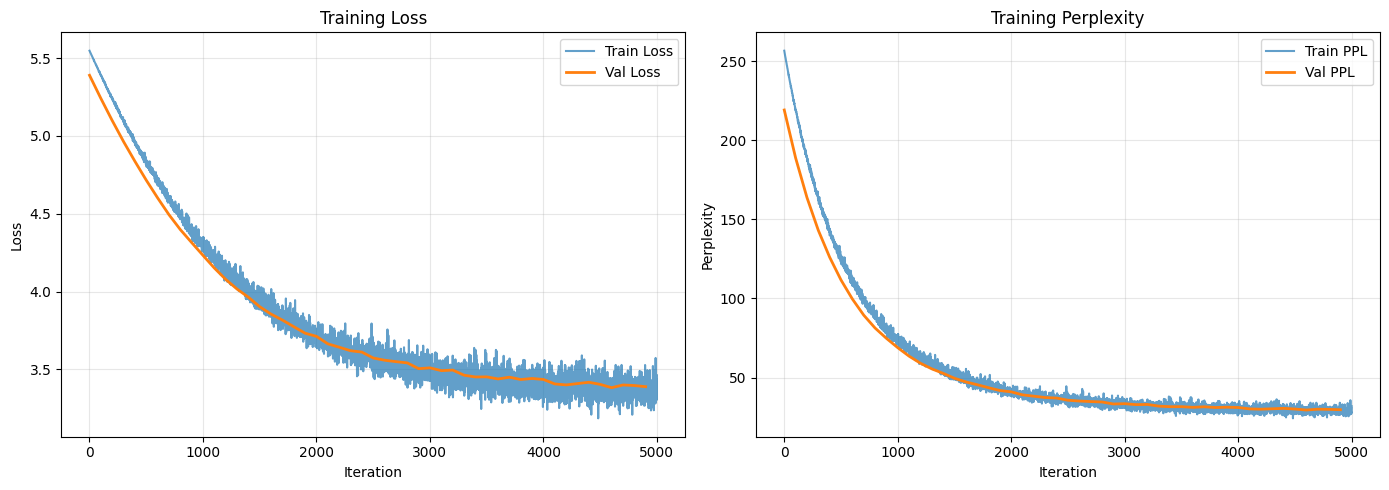


Final Metrics:
  Final Train Loss: 3.4615
  Final Train PPL: 31.87
  Final Val Loss: 3.3882
  Final Val PPL: 29.61
  Best Val Loss: 3.3816


In [9]:
# Plot training curves
metrics.plot_metrics(checkpoint_dir / 'training_metrics.png')

# Save metrics
with open(checkpoint_dir / 'metrics.json', 'w') as f:
    json.dump({
        'train_losses': metrics.train_losses,
        'val_losses': metrics.val_losses,
        'train_perplexities': metrics.train_perplexities,
        'val_perplexities': metrics.val_perplexities
    }, f, indent=2)

print(f"\nFinal Metrics:")
print(f"  Final Train Loss: {metrics.train_losses[-1]:.4f}")
print(f"  Final Train PPL: {metrics.train_perplexities[-1]:.2f}")
print(f"  Final Val Loss: {metrics.val_losses[-1]:.4f}")
print(f"  Final Val PPL: {metrics.val_perplexities[-1]:.2f}")
print(f"  Best Val Loss: {best_val_loss:.4f}")

## 8. Inference Demo with Byte-Level Decoding

In [10]:
model.eval()

# Generate text
prompt = "ROMEO: "
context = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0).to(config.device)

# Prime synaptic state
_, _, persistent_sigma = model(context)

# Generate
current_token = context[:, -1:]
generated_bytes = list(encode(prompt))

for _ in range(500):
    logits, _, persistent_sigma = model(current_token, persistent_sigma=persistent_sigma)
    probs = F.softmax(logits[:, -1, :] / 0.8, dim=-1)
    next_idx = torch.multinomial(probs, num_samples=1)
    
    generated_bytes.append(next_idx.item())
    current_token = next_idx

# Decode bytes to text
generated = decode(generated_bytes)

print("\nGenerated Text:")
print("="*60)
print(generated)
print("="*60)


Generated Text:
ROMEO:  
enns,lh n sef,eRyl lhzaoi,trp  l ct i ehddeif h eeehpw ea et se m u R uAeef

i
o  ln  ny?n k Tnt reto rhn u  nsdf�l' 
eh
lw hnihfaoso ,dyot elt:telnty mao  ot a,dy   effw,fcbaetpdn,ehe yel t :arony  :lin sh
Aboe   i
eie ss Chcttint e Wl e:t oaugt
,'Ape ee wtt ef 
a
eitsneR

o ssPheh t t  mr.ndtir 
S  ,io  erh
coai      o alh  e rclos toesNsoel.aemhrnlu ehhtros.esuasiY a neatrisl yth leesh:uraikos  e me, ei hdyenaoa aslrthshtdrue e asnogu eufr
nsu e? faahnmw e rsI lio
teasptt dkfge a|heg
buym!n


## 9. Save Final Checkpoint

In [11]:
# Save final model
save_checkpoint(model, optimizer, config, metrics.__dict__, checkpoint_dir, 'final_model.pt')

# Save config
with open(checkpoint_dir / 'config.json', 'w') as f:
    json.dump(config.to_dict(), f, indent=2)

print(f"\n✓ All artifacts saved to: {checkpoint_dir}")
print(f"  - best_model.pt (best validation)")
print(f"  - final_model.pt (last checkpoint)")
print(f"  - config.json")
print(f"  - metrics.json")
print(f"  - training_metrics.png")

✓ Saved: bdh_graph_checkpoints/final_model.pt

✓ All artifacts saved to: bdh_graph_checkpoints
  - best_model.pt (best validation)
  - final_model.pt (last checkpoint)
  - config.json
  - metrics.json
  - training_metrics.png
